<a href="https://colab.research.google.com/github/cvt220106/google-colab/blob/main/tf5_10_monkeys_model_2_resnet50_finetune.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [23]:
import json
token = {"username":"jackyyoung","key":"8b0d8fc1f1c33da831ade74e571a01c7"}
with open('/content/kaggle.json','w') as file:
	json.dump(token,file)
# 采用json.dump的好处在于,写入文件的同时,还能保存token的字典格式

In [24]:
!mkdir -p ~/.kaggle
!cp /content/kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json
!kaggle config set -n path -v /content

- path is now set to: /content


In [25]:
!kaggle datasets download -d slothkong/10-monkey-species

10-monkey-species.zip: Skipping, found more recently modified local copy (use --force to force download)


In [26]:
!unzip -o -d /content /content/datasets/slothkong/10-monkey-species/10-monkey-species.zip

Archive:  /content/datasets/slothkong/10-monkey-species/10-monkey-species.zip
  inflating: /content/monkey_labels.txt  
  inflating: /content/training/training/n0/n0018.jpg  
  inflating: /content/training/training/n0/n0019.jpg  
  inflating: /content/training/training/n0/n0020.jpg  
  inflating: /content/training/training/n0/n0021.jpg  
  inflating: /content/training/training/n0/n0022.jpg  
  inflating: /content/training/training/n0/n0023.jpg  
  inflating: /content/training/training/n0/n0024.jpg  
  inflating: /content/training/training/n0/n0025.jpg  
  inflating: /content/training/training/n0/n0026.jpg  
  inflating: /content/training/training/n0/n0027.jpg  
  inflating: /content/training/training/n0/n0028.jpg  
  inflating: /content/training/training/n0/n0029.jpg  
  inflating: /content/training/training/n0/n0030.jpg  
  inflating: /content/training/training/n0/n0031.jpg  
  inflating: /content/training/training/n0/n0032.jpg  
  inflating: /content/training/training/n0/n0033.jpg  


In [27]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import sklearn
import sys
import tensorflow as tf
import time

from tensorflow import keras

print(tf.__version__)
print(sys.version_info)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)

2.8.2
sys.version_info(major=3, minor=7, micro=13, releaselevel='final', serial=0)
matplotlib 3.2.2
numpy 1.21.6
pandas 1.3.5
sklearn 1.0.2
tensorflow 2.8.2
tensorflow.keras 2.8.0


In [28]:
train_dir = "./training/training"
valid_dir = "./validation/validation"
label_file = "./monkey_labels.txt"
print(os.path.exists(train_dir))
print(os.path.exists(valid_dir))
print(os.path.exists(label_file))

print(os.listdir(train_dir))
print(os.listdir(valid_dir))

True
True
True
['n5', 'n1', 'n0', 'n7', 'n8', 'n2', 'n6', 'n9', 'n4', 'n3']
['n5', 'n1', 'n0', 'n7', 'n8', 'n2', 'n6', 'n9', 'n4', 'n3']


In [29]:
labels = pd.read_csv(label_file, header=0)
print(labels)

   Label     Latin Name              Common Name                     \
0  n0         alouatta_palliata\t    mantled_howler                   
1  n1        erythrocebus_patas\t    patas_monkey                     
2  n2        cacajao_calvus\t        bald_uakari                      
3  n3        macaca_fuscata\t        japanese_macaque                 
4  n4       cebuella_pygmea\t        pygmy_marmoset                   
5  n5       cebus_capucinus\t        white_headed_capuchin            
6  n6       mico_argentatus\t        silvery_marmoset                 
7  n7      saimiri_sciureus\t        common_squirrel_monkey           
8  n8       aotus_nigriceps\t        black_headed_night_monkey        
9  n9       trachypithecus_johnii    nilgiri_langur                   

    Train Images    Validation Images  
0             131                  26  
1             139                  28  
2             137                  27  
3             152                  30  
4             131 

In [30]:
#因为resnet处理的224，因为要改为
height = 224
width = 224
channels = 3
#图形变大了，我们改小batch_size
batch_size = 24
num_classes = 10

train_datagen = keras.preprocessing.image.ImageDataGenerator(
    #这里也要改为resnet50，resnet50是karas中，为tf，torch都做了适配
    #preprocess_input主要做了归一化和白化
    preprocessing_function = keras.applications.resnet50.preprocess_input,
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = 'nearest',
)
train_generator = train_datagen.flow_from_directory(train_dir,
                                                   target_size = (height, width),
                                                   batch_size = batch_size,
                                                   seed = 7,
                                                   shuffle = True,
                                                   class_mode = "categorical")
#这里也需要修改
valid_datagen = keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function = keras.applications.resnet50.preprocess_input)
valid_generator = valid_datagen.flow_from_directory(valid_dir,
                                                    target_size = (height, width),
                                                    batch_size = batch_size,
                                                    seed = 7,
                                                    shuffle = False,
                                                    class_mode = "categorical")
train_num = train_generator.samples
valid_num = valid_generator.samples
print(train_num, valid_num)

Found 1098 images belonging to 10 classes.
Found 272 images belonging to 10 classes.
1098 272


In [10]:
for i in range(2):
    x, y = train_generator.next()
    print(x.shape, y.shape)
    print(y)

(24, 224, 224, 3) (24, 10)
[[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]
(24, 224, 224, 3) (24, 10)
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0

In [11]:
resnet50_fine_tune = keras.models.Sequential()
#resnet有1000个分类，我们只有10类，最后一层要去掉，最后的输出是三维矩阵，而不是一维的，
# 我们通过pooling = 'avg'解决这个问题
# pooling size 是（2，2）的时候是大小减半，而pooling size恰好等于图像大小的时候，就可以降维。
resnet50_fine_tune.add(keras.applications.ResNet50(include_top = False,
                                                   pooling = 'avg',
                #weights = 'imagenet'就会下载imagenet，在这个初始化好的基础上去训练
                                                   weights = 'imagenet'))
#加一个全连接层num_classes值为10，相当于只调整最后的参数
resnet50_fine_tune.add(keras.layers.Dense(num_classes, activation = 'softmax'))
print(resnet50_fine_tune.layers)
resnet50_fine_tune.layers[0].trainable = False

resnet50_fine_tune.compile(loss="categorical_crossentropy",
                           optimizer="sgd", metrics=['accuracy'])
resnet50_fine_tune.summary()

94781440/94765736 [==============================] - 1s 0us/step
[<keras.engine.functional.Functional object at 0x7f8df41ef150>, <keras.layers.core.dense.Dense object at 0x7f8dfc9e2490>]
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense (Dense)               (None, 10)                20490     
                                                                 
Total params: 23,608,202
Trainable params: 20,490
Non-trainable params: 23,587,712
_________________________________________________________________


In [12]:
# resnet50_fine_tune.variables

In [13]:

epochs = 10
history = resnet50_fine_tune.fit_generator(train_generator,
                                           steps_per_epoch = train_num // batch_size,
                                           epochs = epochs,
                                           validation_data = valid_generator,
                                           validation_steps = valid_num // batch_size)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  import sys


Epoch 1/10
45/45 [==============================] - 59s 926ms/step - loss: 1.0692 - accuracy: 0.6946 - val_loss: 0.4665 - val_accuracy: 0.8902
Epoch 2/10
45/45 [==============================] - 42s 936ms/step - loss: 0.3310 - accuracy: 0.9385 - val_loss: 0.2773 - val_accuracy: 0.9356
Epoch 3/10
45/45 [==============================] - 40s 885ms/step - loss: 0.2122 - accuracy: 0.9665 - val_loss: 0.2068 - val_accuracy: 0.9545
Epoch 4/10
45/45 [==============================] - 40s 892ms/step - loss: 0.1594 - accuracy: 0.9702 - val_loss: 0.1927 - val_accuracy: 0.9508
Epoch 5/10
45/45 [==============================] - 41s 922ms/step - loss: 0.1321 - accuracy: 0.9795 - val_loss: 0.1450 - val_accuracy: 0.9545
Epoch 6/10
45/45 [==============================] - 40s 897ms/step - loss: 0.1246 - accuracy: 0.9758 - val_loss: 0.1482 - val_accuracy: 0.9621
Epoch 7/10
45/45 [==============================] - 40s 903ms/step - loss: 0.1103 - accuracy: 0.9730 - val_loss: 0.1287 - val_accuracy: 0.9621

In [14]:
# resnet50_fine_tune.variables

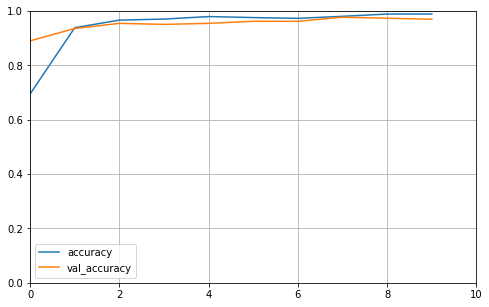

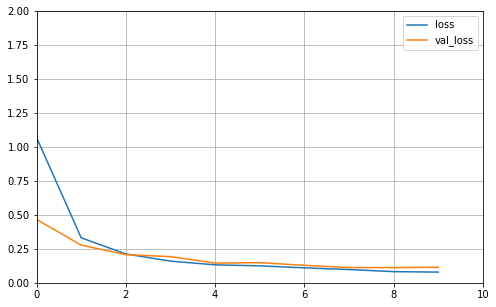

In [15]:
def plot_learning_curves(history, label, epcohs, min_value, max_value):
    data = {}
    data[label] = history.history[label]
    data['val_'+label] = history.history['val_'+label]
    pd.DataFrame(data).plot(figsize=(8, 5))
    plt.grid(True)
    plt.axis([0, epochs, min_value, max_value])
    plt.show()
    
plot_learning_curves(history, 'accuracy', epochs, 0, 1)
plot_learning_curves(history, 'loss', epochs, 0, 2)

In [31]:
#另外一种实现
resnet50 = keras.applications.ResNet50(include_top = True,
                                       pooling = 'avg',
                                       weights = None,classes=10)
resnet50.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [32]:
len(resnet50.layers)

177

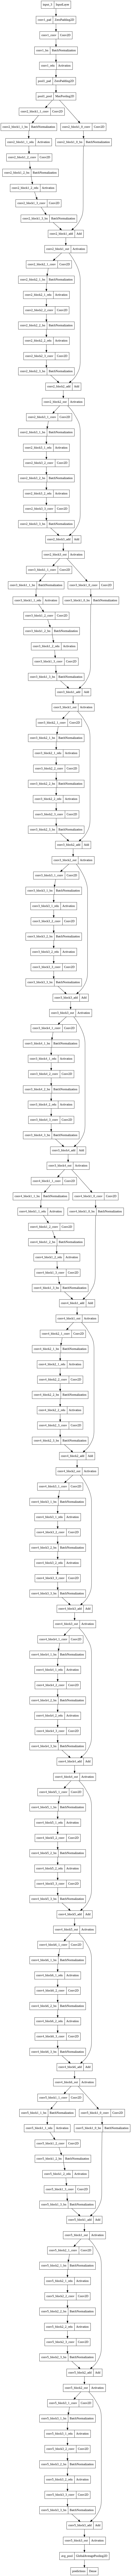

In [33]:
from tensorflow.keras.utils import plot_model

plot_model(resnet50)


In [34]:
#设置只有最后的5层可以训练,前面的45层不能训练
for layer in resnet50.layers[0:-5]:
    layer.trainable = False

resnet50_new = keras.models.Sequential([
    resnet50,
    keras.layers.Dense(num_classes, activation = 'softmax'),
])
resnet50_new.compile(loss="categorical_crossentropy",
                     optimizer="sgd", metrics=['accuracy'])
resnet50_new.summary()
#可以看到我们的params大大增加了

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 10)                23608202  
                                                                 
 dense_2 (Dense)             (None, 10)                110       
                                                                 
Total params: 23,608,312
Trainable params: 24,696
Non-trainable params: 23,583,616
_________________________________________________________________


In [35]:
#增加了以后准确率变化了，两个原因，第二个可训练参数变多，2 我们增加的层进行了调整
epochs = 10
history = resnet50_new.fit(train_generator,
                                     steps_per_epoch = train_num // batch_size,
                                     epochs = epochs,
                                     validation_data = valid_generator,
                                     validation_steps = valid_num // batch_size)

Epoch 1/10
45/45 [==============================] - 46s 947ms/step - loss: 2.3492 - accuracy: 0.0931 - val_loss: 2.3497 - val_accuracy: 0.0985
Epoch 2/10
45/45 [==============================] - 40s 883ms/step - loss: 2.3383 - accuracy: 0.0978 - val_loss: 2.3428 - val_accuracy: 0.0985
Epoch 3/10
45/45 [==============================] - 40s 889ms/step - loss: 2.3338 - accuracy: 0.0968 - val_loss: 2.3368 - val_accuracy: 0.0985
Epoch 4/10
45/45 [==============================] - 41s 914ms/step - loss: 2.3289 - accuracy: 0.0950 - val_loss: 2.3316 - val_accuracy: 0.0985
Epoch 5/10
45/45 [==============================] - 41s 905ms/step - loss: 2.3253 - accuracy: 0.0885 - val_loss: 2.3271 - val_accuracy: 0.0985
Epoch 6/10
45/45 [==============================] - 41s 921ms/step - loss: 2.3227 - accuracy: 0.0912 - val_loss: 2.3232 - val_accuracy: 0.0985
Epoch 7/10
45/45 [==============================] - 40s 899ms/step - loss: 2.3170 - accuracy: 0.0950 - val_loss: 2.3202 - val_accuracy: 0.1023

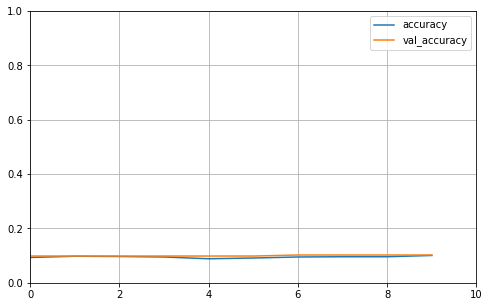

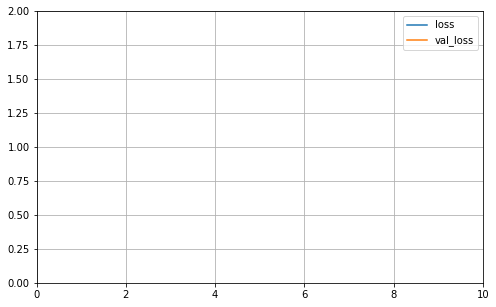

In [36]:
plot_learning_curves(history, 'accuracy', epochs, 0, 1)
plot_learning_curves(history, 'loss', epochs, 0, 2)